### Helper functions

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def load_data(filename):
    """
    Load the data from the file and return the distance matrix and the coordinates of the nodes.
    """
    with open(filename) as f:
        lines = f.readlines()

    nodes = []
    reading_coords = False
    for line in lines:
        if "NODE_COORD_SECTION" in line:
            reading_coords = True
            continue
        if "EOF" in line:
            break
        if reading_coords:
            parts = line.strip().split()
            if len(parts) == 3:
                _, x, y = parts
                nodes.append((float(x), float(y)))
    nodes = np.array(nodes)
    num_nodes = len(nodes)
    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

    for i in range(num_nodes):
        for j in range(i+1,num_nodes):
            dist = np.sqrt((nodes[i,0]-nodes[j,0])**2 + (nodes[i,1]-nodes[j,1])**2)
            distance_matrix[i,j] = dist
            distance_matrix[j,i] = dist
    return distance_matrix, nodes

def split_nodes(num_nodes, nodes, method="random"):
    """
    Split the nodes into two balanced sets.
    :param num_nodes: Number of nodes.
    :param nodes: Coordinates of the nodes.
    :param method: Splitting method ('random', 'sequential', or 'smart').
    :return: Two lists of node indices.
    """
    indices = np.arange(num_nodes)
    
    if method == "random":
        np.random.shuffle(indices) 
    
    elif method == "smart":
        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        labels = kmeans.fit_predict(nodes)  
        centroids = kmeans.cluster_centers_  

        group_1 = indices[labels == 0].tolist()
        group_2 = indices[labels == 1].tolist()

        
        while abs(len(group_1) - len(group_2)) > 1:
            if len(group_1) > len(group_2):
                larger_group, smaller_group = group_1, group_2
                smaller_centroid = centroids[1]
            else:
                larger_group, smaller_group = group_2, group_1
                smaller_centroid = centroids[0]

            # Find the node in the larger group that is closest to the centroid of the smaller group
            distances = {node: np.linalg.norm(nodes[node] - smaller_centroid) for node in larger_group}
            best_transfer = min(distances, key=distances.get) 

            
            larger_group.remove(best_transfer)
            smaller_group.append(best_transfer)

        return group_1, group_2

    # Split the indices into two equal parts for other methods
    split_point = num_nodes // 2  
    return indices[:split_point].tolist(), indices[split_point:].tolist()

def calculate_cycle_length(distance_matrix, tour):
    """
    Calculates the length of a cycle based on a distance matrix.
    :param distance_matrix: The distance matrix.
    :param tour: A list of vertices in the cycle.
    :return: The length of the cycle.
    """
    length = sum(distance_matrix[tour[i], tour[i + 1]] for i in range(len(tour) - 1))
    length += distance_matrix[tour[-1], tour[0]]  # close the cycle
    return length


### Algorytm najbliższego sąsiada

In [58]:
def nearest_neighbor_two_cycles(distance_matrix, groups, node_start_method = 'random'):
    """
    Makes two disjoint cycles using the nearest neighbor method.
    :param distance_matrix: The distance matrix.
    :param groups: Two lists of node indices.
    :param node_start_method: The method of choosing the starting vertex ('random' or 'sequential').
    :return: Two lists of visited vertices (two cycles).
    """
    num_nodes = len(distance_matrix)
    group1, group2 = groups

    def nn_tour(subset):
        if node_start_method == 'random':
            start_node = np.random.choice(subset)
        if node_start_method == 'sequential':
            start_node = subset[0]
        unvisited = set(subset)
        unvisited.remove(start_node)
        tour = [start_node]
        current = start_node

        while unvisited:
            nearest = min(unvisited, key=lambda node: distance_matrix[current, node])
            tour.append(nearest)
            unvisited.remove(nearest)
            current = nearest

        return tour

    return nn_tour(group1), nn_tour(group2)


### Algorytm rozbudowy cyklu

In [59]:
def greedy_cycle_two_cycles(distance_matrix, groups, node_start_method = 'random'):
    """
    Makes two disjoint cycles using greedy cycle expansion method.
    :param distance_matrix: Distance matrix.
    :param groups: Two lists of node indices.
    :param method: Method of splitting vertices ('random' or 'sequential').
    :return: Two lists of visited vertices (two cycles).
    """

    num_nodes = len(distance_matrix)
    group1, group2 = groups

    def greedy_cycle(subset):
        """
        Makes a cycle using greedy cycle expansion method.
        :param distance_matrix: Distance matrix.
        :param subset: List of vertices to visit.
        :return: List of visited vertices (cycle).
        """

        if node_start_method == 'random':
            start_node = np.random.choice(subset)
        if node_start_method == 'sequential':
            start_node = subset[0]
        unvisited = set(subset)
        unvisited.remove(start_node)

        # Find the nearest node to the starting node
        nearest = min(unvisited, key=lambda node: distance_matrix[start_node, node])
        unvisited.remove(nearest)

        tour = [start_node, nearest]

        while unvisited:
            best_node, best_position, min_increase = None, None, float('inf')

            # Find the best node to insert into the tour
            for node in unvisited:
                for i in range(len(tour)):
                    a, b = tour[i], tour[(i + 1) % len(tour)]
                    increase = (
                        distance_matrix[a, node] +
                        distance_matrix[node, b] -
                        distance_matrix[a, b]
                    )
                    if increase < min_increase:
                        best_node, best_position, min_increase = node, i + 1, increase

            tour.insert(best_position, best_node)
            unvisited.remove(best_node)

        return tour


    return greedy_cycle(group1), greedy_cycle(group2)



### Algorytm 2-żalu

In [60]:
def regret_heuristic_two_cycles(distance_matrix, groups, node_start_method='random'):
    """
    Makes two disjoint cycles using regret cycle expansion method.
    :param distance_matrix: Distance matrix.
    :param groups: Two lists of node indices.
    :param node_start_method: Method of selecting the starting node ('random' or 'sequential').
    :return: Two lists of visited vertices (two cycles).
    """
    
    num_nodes = len(distance_matrix)
    group1, group2 = groups
    
    def regret_cycle(subset):
        """
        Makes a cycle using regret cycle expansion method.
        :param subset: List of vertices to visit.
        :return: List of visited vertices (cycle).
        """
        if node_start_method == 'random':
            start_node = np.random.choice(subset)
        elif node_start_method == 'sequential':
            start_node = subset[0]
        
        unvisited = set(subset)
        unvisited.remove(start_node)
    
        nearest = min(unvisited, key=lambda node: distance_matrix[start_node, node])
        unvisited.remove(nearest)
        
        # Starting tour with two nodes
        tour = [start_node, nearest]
        
        while unvisited:
            best_node, best_position, max_regret = None, None, -np.inf
            
            for node in unvisited:
                min_cost = np.inf
                second_min_cost = np.inf
                best_pos = None

                # Find the best position to insert the node
                for i in range(len(tour)):
                    a, b = tour[i], tour[(i + 1) % len(tour)]
                    cost = distance_matrix[a, node] + distance_matrix[node, b] - distance_matrix[a, b]
                    
                    if cost < min_cost:
                        second_min_cost = min_cost
                        min_cost = cost
                        best_pos = i + 1
                    elif cost < second_min_cost:
                        second_min_cost = cost
                
                regret = second_min_cost - min_cost
                if regret > max_regret:
                    best_node, best_position, max_regret = node, best_pos, regret
            
            tour.insert(best_position, best_node)
            unvisited.remove(best_node)
        
        return tour
    
    return regret_cycle(group1), regret_cycle(group2)

In [61]:
def weighted_regret_heuristic_two_cycles(distance_matrix, groups, lambda_regret=1, node_start_method='random'):
    """
    Tworzy dwa rozłączne cykle za pomocą ważonej heurystyki 2-żalu.
    
    :param distance_matrix: Macierz odległości.
    :param groups: Dwie listy indeksów wierzchołków (podział na dwie grupy).
    :param lambda_regret: Współczynnik wagi dla wartości żalu (domyślnie 1.5).
    :param node_start_method: Metoda wyboru wierzchołka początkowego ('random' lub 'sequential').
    :return: Dwie listy odwiedzonych wierzchołków (dwa cykle).
    """
    
    def weighted_regret_cycle(subset):
        """
        Tworzy cykl dla danej grupy wierzchołków, używając ważonego 2-żalu.
        :param subset: Lista wierzchołków do odwiedzenia.
        :return: Lista odwiedzonych wierzchołków (cykl).
        """
        if node_start_method == 'random':
            start_node = np.random.choice(subset)
        elif node_start_method == 'sequential':
            start_node = subset[0]
        
        unvisited = set(subset)
        unvisited.remove(start_node)
    
        nearest = min(unvisited, key=lambda node: distance_matrix[start_node, node])
        unvisited.remove(nearest)
        
        # Inicjalizacja cyklu dwoma wierzchołkami
        tour = [start_node, nearest]
        
        while unvisited:
            best_node, best_position, max_weighted_regret = None, None, -np.inf
            
            for node in unvisited:
                min_cost = np.inf
                second_min_cost = np.inf
                best_pos = None

                # Znalezienie najlepszego miejsca do wstawienia wierzchołka
                for i in range(len(tour)):
                    a, b = tour[i], tour[(i + 1) % len(tour)]
                    cost = distance_matrix[a, node] + distance_matrix[node, b] - distance_matrix[a, b]
                    
                    if cost < min_cost:
                        second_min_cost = min_cost
                        min_cost = cost
                        best_pos = i + 1
                    elif cost < second_min_cost:
                        second_min_cost = cost
                
                regret = second_min_cost - min_cost
                weighted_regret = lambda_regret * regret # WAŻONY 2-ŻAL
                
                if weighted_regret > max_weighted_regret:
                    best_node, best_position, max_weighted_regret = node, best_pos, weighted_regret
            
            tour.insert(best_position, best_node)
            unvisited.remove(best_node)
        
        return tour
    
    group1, group2 = groups
    return weighted_regret_cycle(group1), weighted_regret_cycle(group2)

### Funkcja odpowiedzialna za rysowanie cykli

In [ ]:
def plot_two_tours(node_coords, cycle1, cycle2, title="TSP Two Cycles"):
    """
    Draw two disjoint TSP cycles.
    :param node_coords: Coordinates of nodes.
    :param cycle1: List of visited nodes in the first cycle.
    :param cycle2: List of visited nodes in the second cycle.
    :param title: Title of the plot.
    """
    plt.figure(figsize=(8, 8))
    
    # Draw first cycle
    cycle1_coords = node_coords[cycle1 + [cycle1[0]]]
    plt.plot(cycle1_coords[:, 0], cycle1_coords[:, 1], 'o-', markersize=5, color='blue', label="Cykl 1")
    
    # Draw second cycle
    cycle2_coords = node_coords[cycle2 + [cycle2[0]]]
    plt.plot(cycle2_coords[:, 0], cycle2_coords[:, 1], 'o-', markersize=5, color='green', label="Cykl 2")
    
    # Mark the starting nodes
    plt.scatter(node_coords[cycle1[0], 0], node_coords[cycle1[0], 1], color='red', s=100, label="Start Cykl 1")
    plt.scatter(node_coords[cycle2[0], 0], node_coords[cycle2[0], 1], color='orange', s=100, label="Start Cykl 2")

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig()

In [63]:
distance_matrix_A, nodesA = load_data("kroA200.tsp")
distance_matrix_B, nodesB = load_data("kroB200.tsp")



### Testing split method: smart ###

kroA200 - group 1: 100 vertices
kroA200 - group 2: 100 vertices
kroB200 - group 1: 100 vertices
kroB200 - group 2: 100 vertices
kroA200 - Nearest Neighbor - smart - done
kroA200 - Nearest Neighbor - smart - done
kroA200 - Greedy Cycle - smart - done
kroA200 - Greedy Cycle - smart - done
kroA200 - Regret Heuristic - smart - done
kroA200 - Regret Heuristic - smart - done
kroA200 - Weighted Regret Heuristic 0.5 - smart - done
kroA200 - Weighted Regret Heuristic 0.5 - smart - done
kroA200 - Weighted Regret Heuristic 1.5 - smart - done
kroA200 - Weighted Regret Heuristic 1.5 - smart - done
kroB200 - Nearest Neighbor - smart - done
kroB200 - Nearest Neighbor - smart - done
kroB200 - Greedy Cycle - smart - done
kroB200 - Greedy Cycle - smart - done
kroB200 - Regret Heuristic - smart - done
kroB200 - Regret Heuristic - smart - done
kroB200 - Weighted Regret Heuristic 0.5 - smart - done
kroB200 - Weighted Regret Heuristic 0.5 - smart - done
kroB200 - Weight

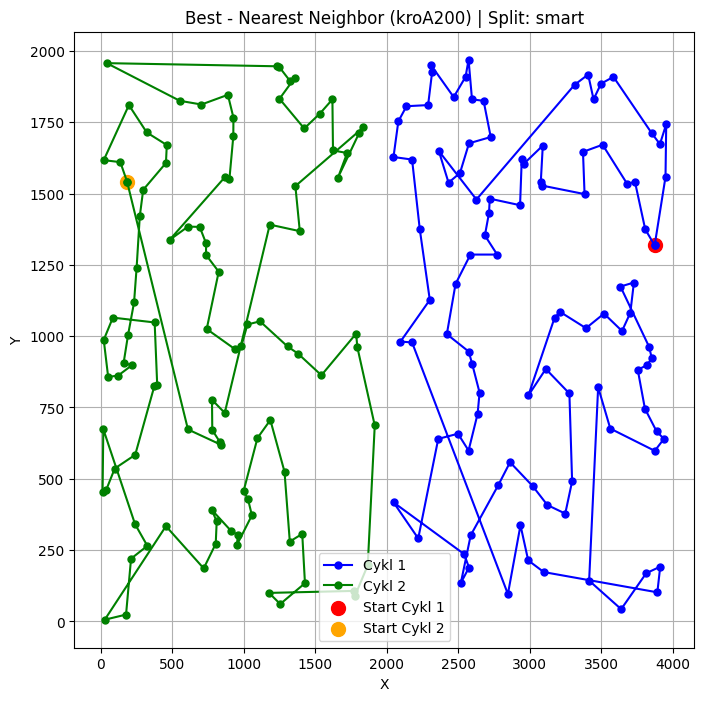

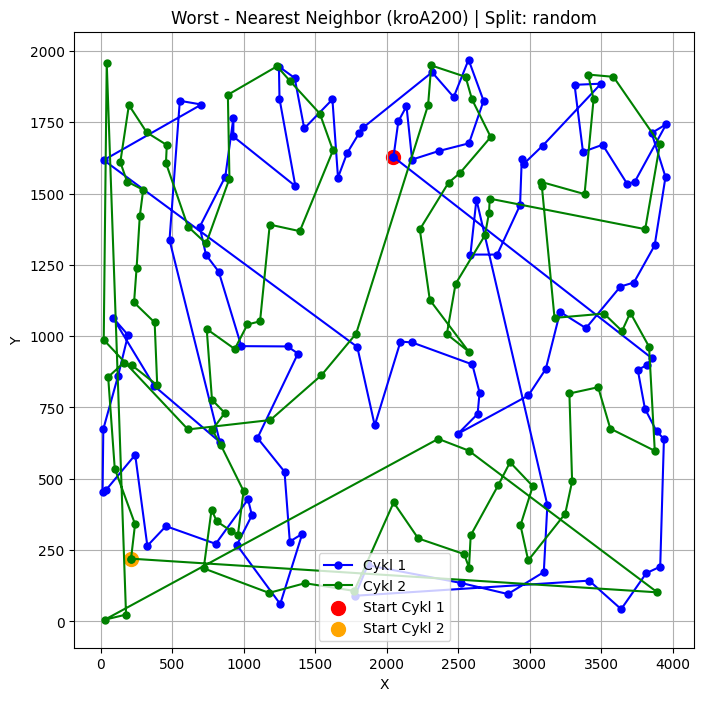

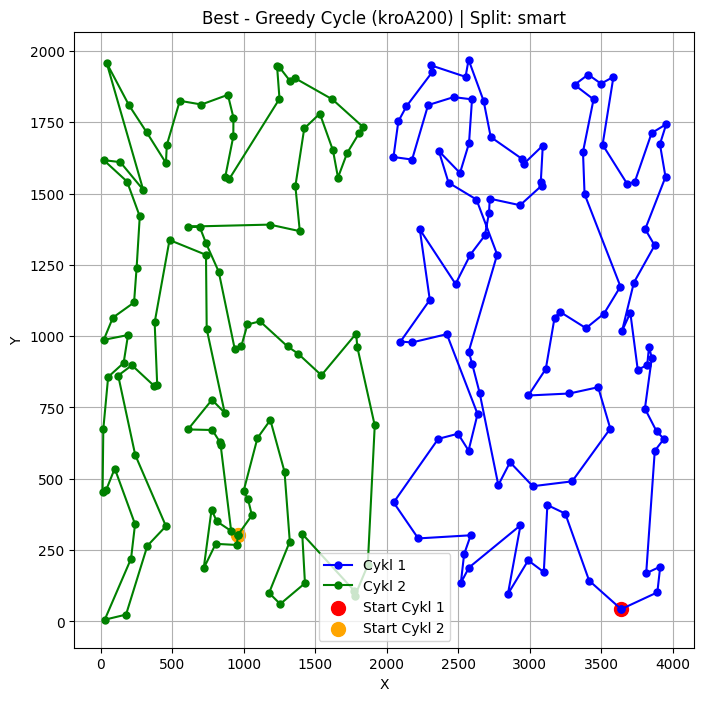

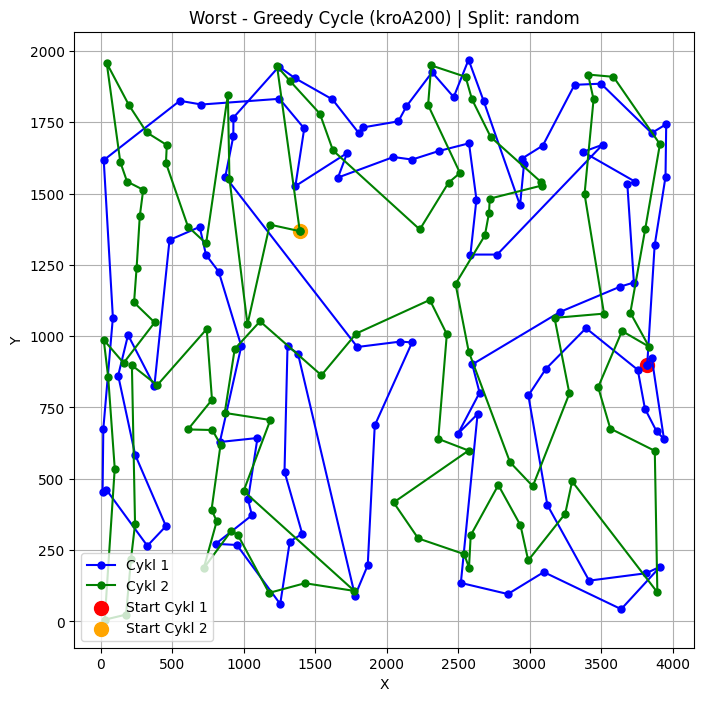

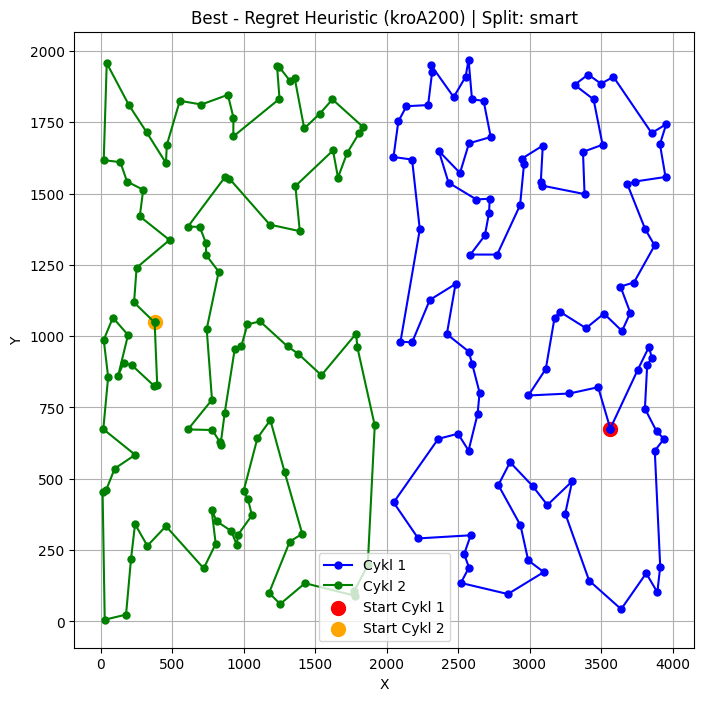

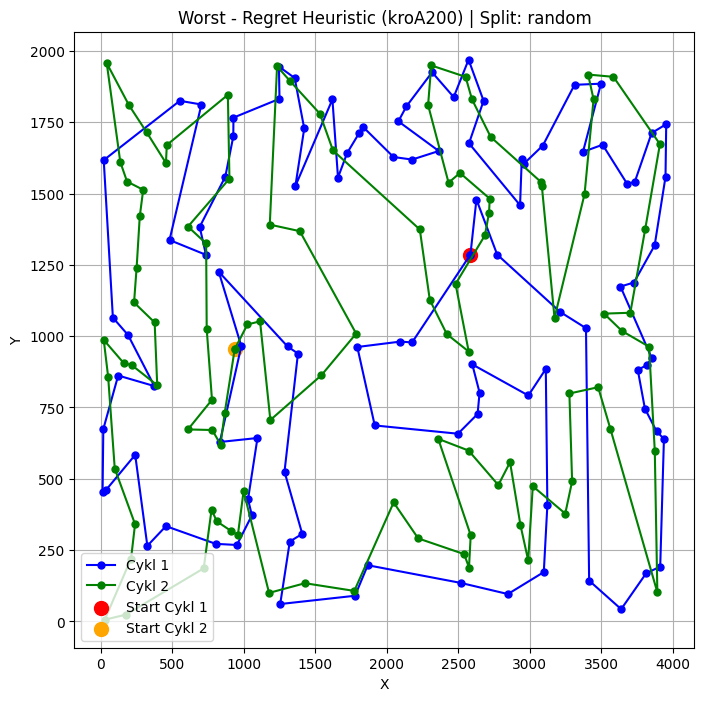

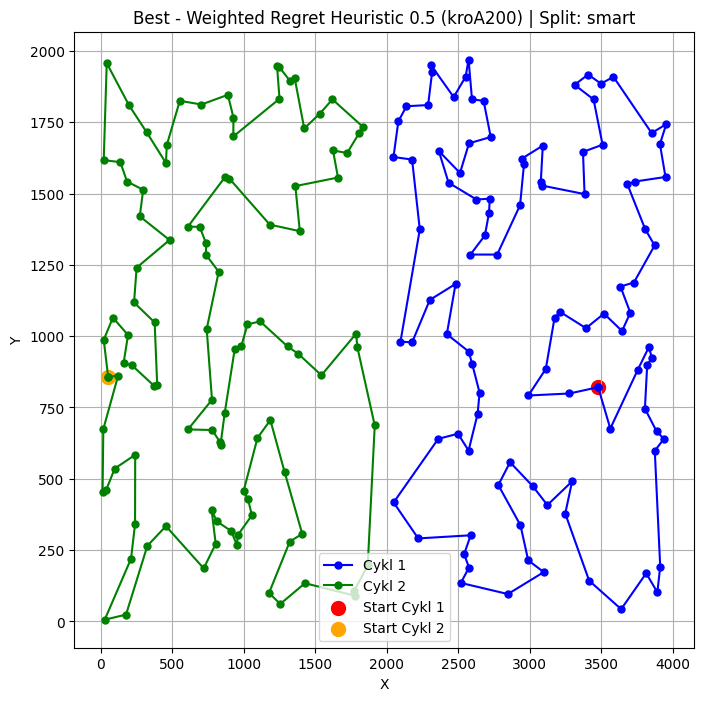

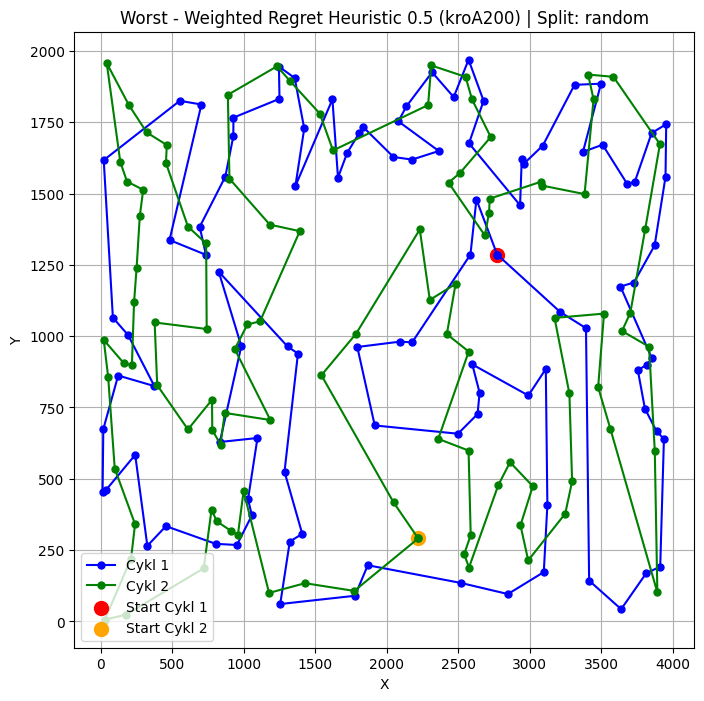

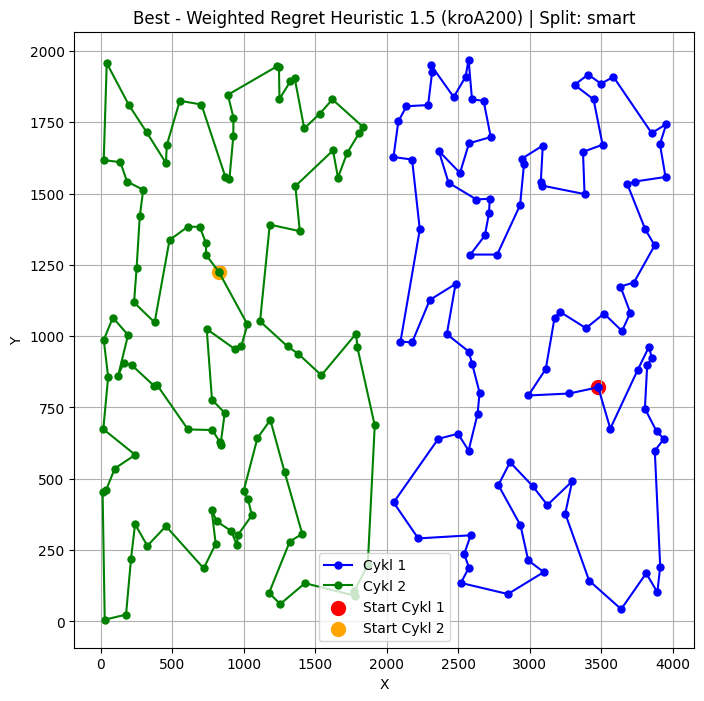

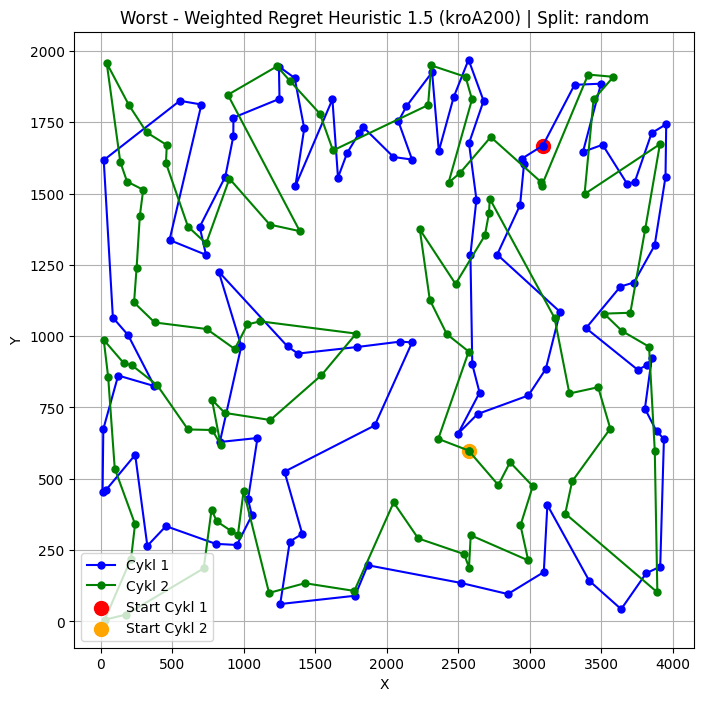

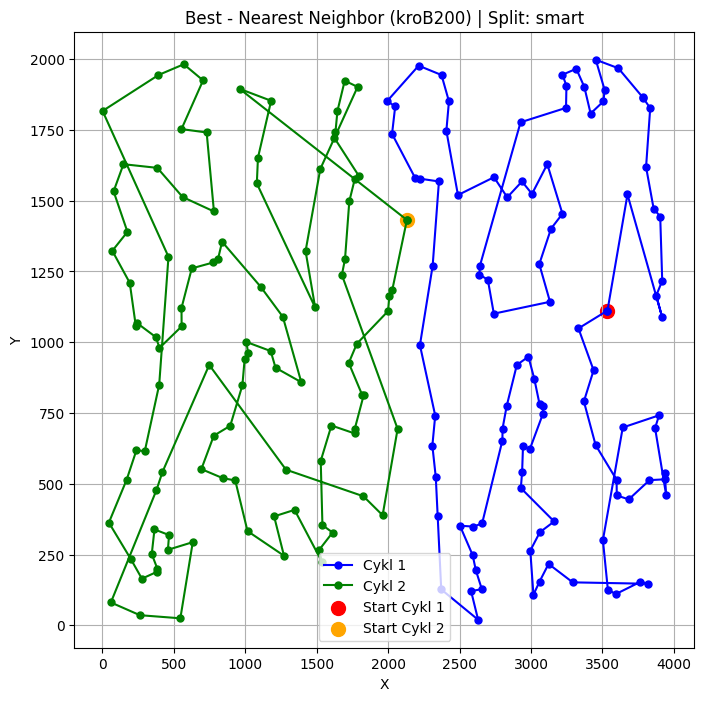

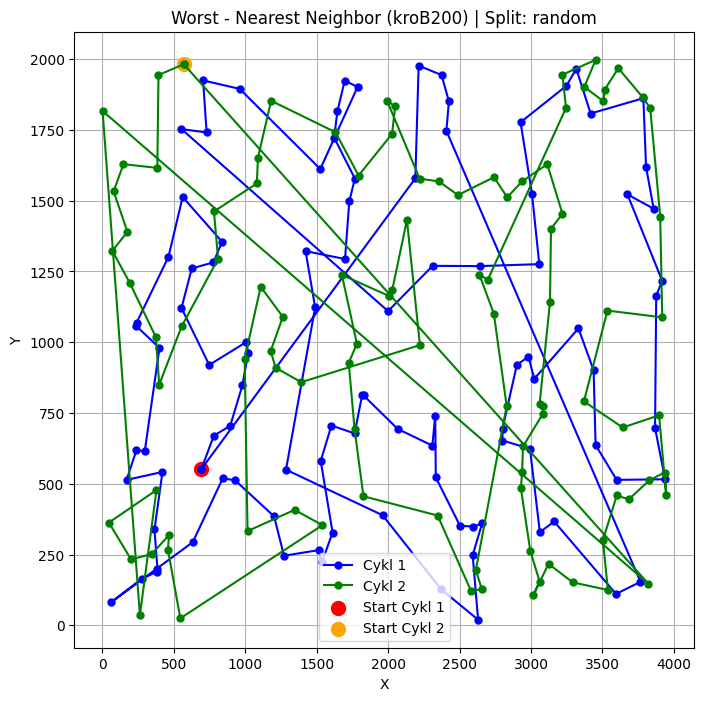

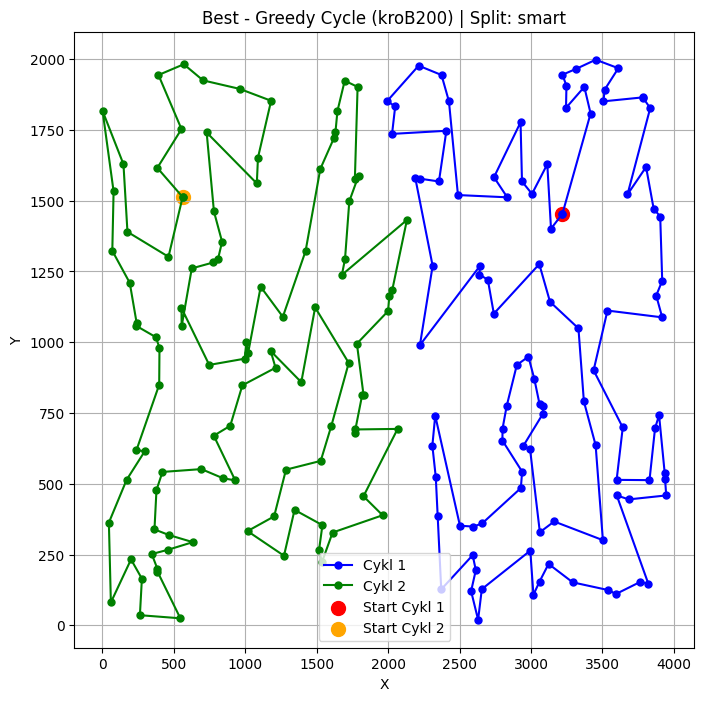

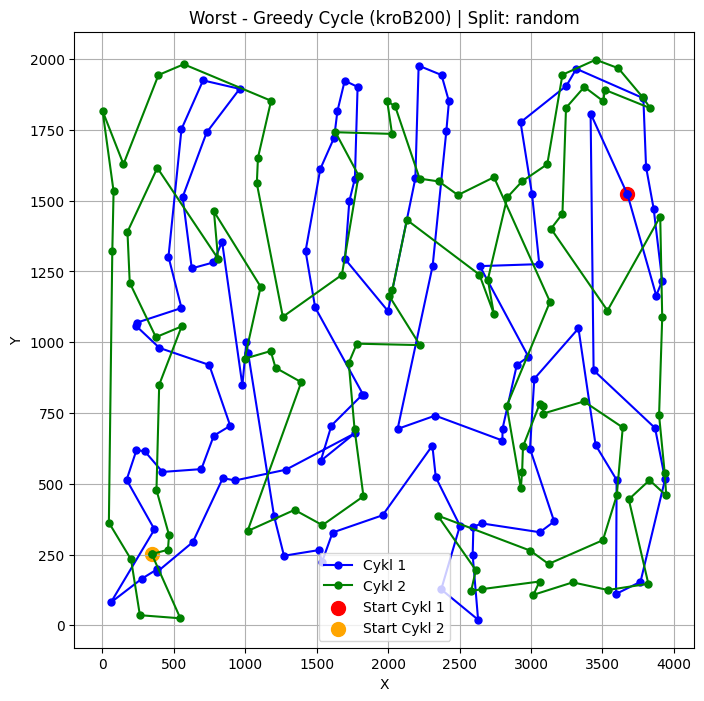

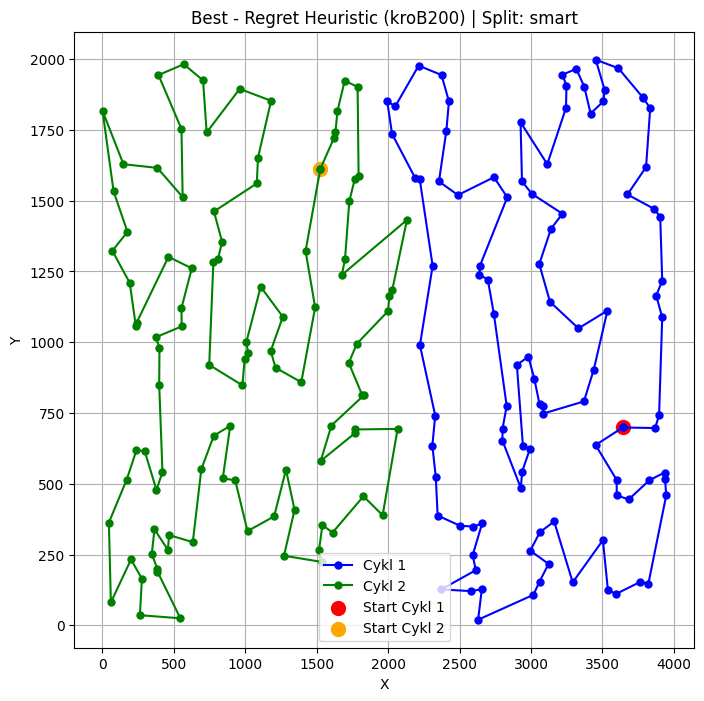

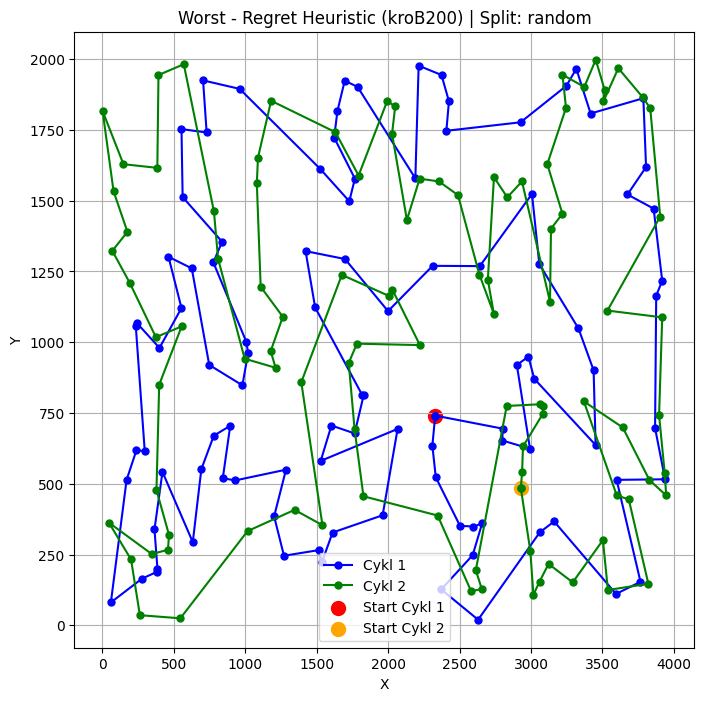

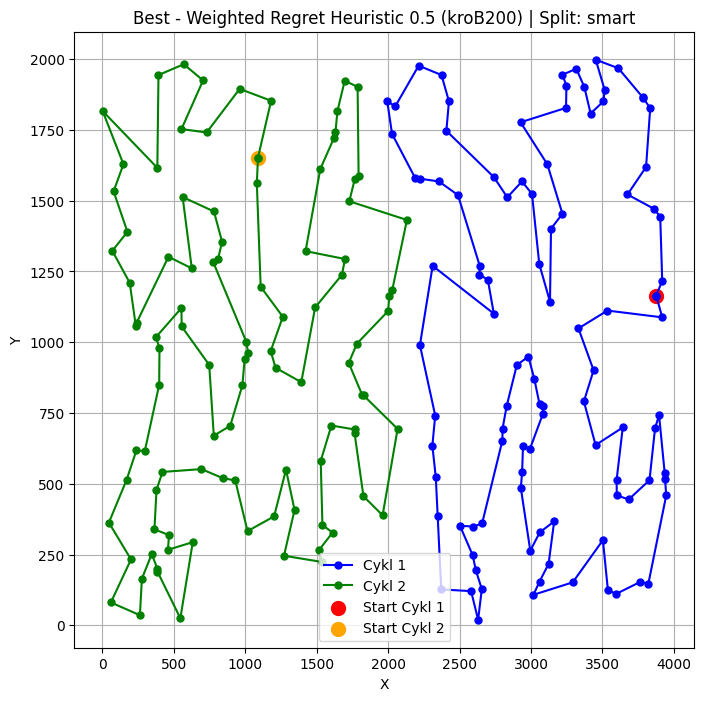

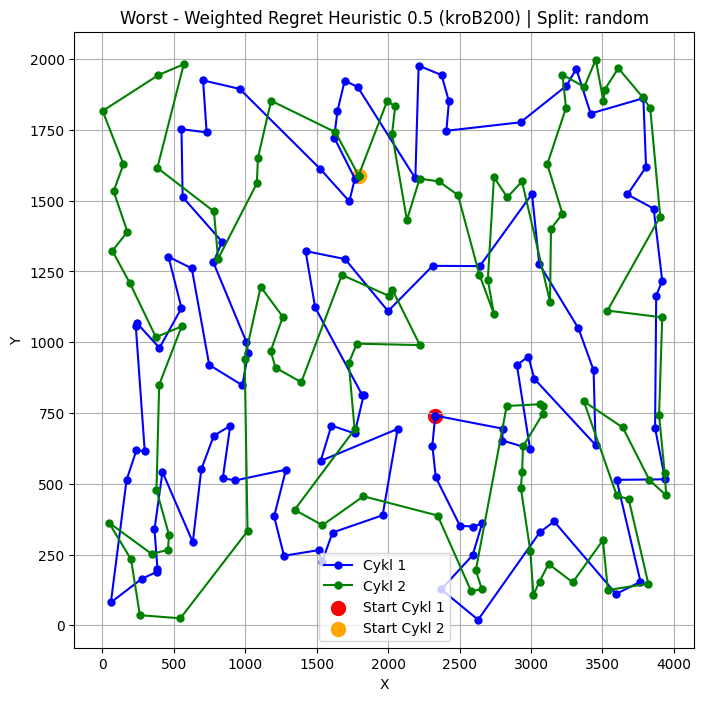

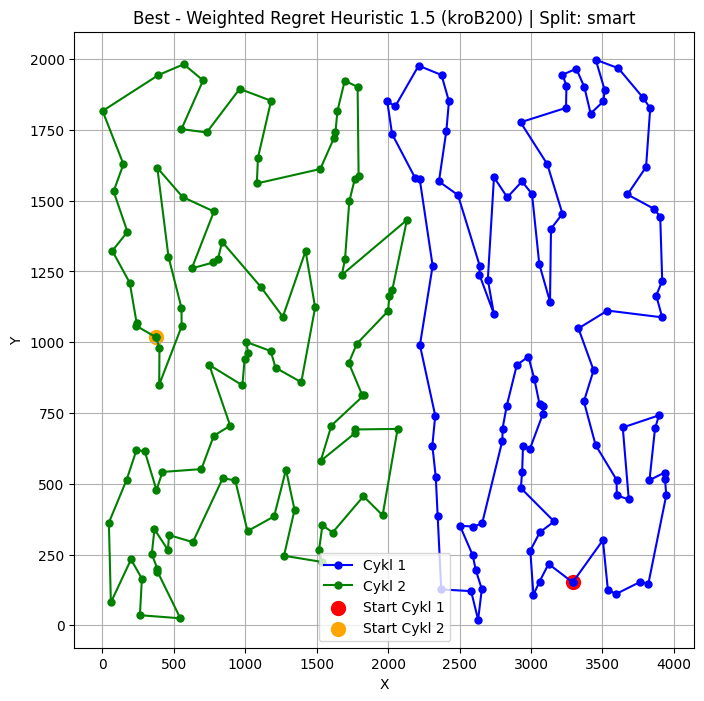

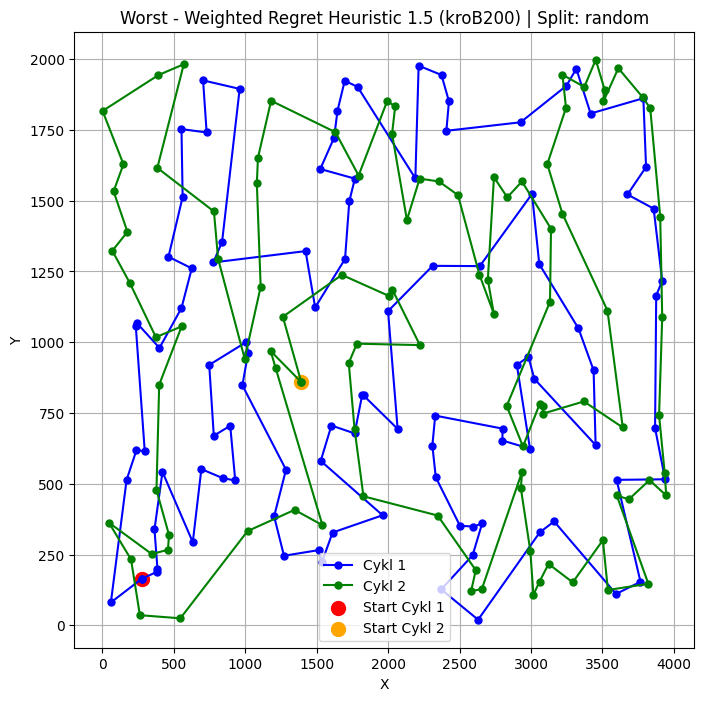

{'kroA200': {'Nearest Neighbor': [('smart', 18704, 18477, [186, 5, 108, 106, 156, 46, 30, 66, 161, 63, 19, 54, 41, 134, 185, 126, 111, 119, 154, 182, 21, 133, 7, 74, 53, 150, 160, 124, 180, 1, 34, 168, 67, 29, 88, 40, 139, 20, 153, 163, 22, 172, 149, 90, 93, 94, 49, 184, 167, 61, 82, 71, 129, 70, 37, 27, 38, 87, 147, 199, 170, 57, 140, 97, 113, 102, 145, 128, 142, 89, 33, 24, 16, 55, 151, 177, 195, 4, 104, 42, 136, 85, 138, 181, 194, 112, 132, 175, 75, 69, 143, 101, 76, 157, 79, 64, 176, 12, 78, 159], [39, 146, 11, 45, 171, 120, 173, 158, 23, 31, 135, 60, 25, 198, 77, 8, 137, 123, 117, 15, 62, 187, 43, 115, 121, 193, 50, 178, 65, 152, 47, 83, 10, 51, 169, 165, 164, 95, 125, 86, 103, 96, 80, 44, 196, 32, 99, 155, 73, 56, 35, 13, 191, 107, 141, 68, 188, 130, 179, 2, 72, 58, 166, 127, 192, 59, 100, 3, 162, 92, 105, 148, 189, 48, 17, 109, 28, 183, 36, 81, 6, 116, 114, 52, 0, 110, 131, 84, 144, 190, 197, 26, 122, 14, 98, 18, 91, 9, 174, 118]), ('smart', 20311, 17964, [132, 175, 112, 194, 18

In [121]:
split_methods = ["smart", "random", "sequential"]
n_runs=100
np.random.seed(2137) 
nodes = {
    "kroA200": nodesA,
    "kroB200": nodesB
}
instances = {
    "kroA200": distance_matrix_A,
    "kroB200": distance_matrix_B
}
heuristics = {
    "Nearest Neighbor": nearest_neighbor_two_cycles,
    "Greedy Cycle": greedy_cycle_two_cycles,
    "Regret Heuristic": weighted_regret_heuristic_two_cycles,
    "Weighted Regret Heuristic 0.5": weighted_regret_heuristic_two_cycles,
    "Weighted Regret Heuristic 1.5": weighted_regret_heuristic_two_cycles
    
}
results = {}

for split_method in split_methods:
    print(f"\n### Testing split method: {split_method} ###\n")

    groups = {
        "kroA200": split_nodes(len(nodesA), nodesA, split_method),
        "kroB200": split_nodes(len(nodesB), nodesB, split_method)
    }
    
    # Check if the groups are balanced
    for instance_name, (group1, group2) in groups.items():
        if(len(group1) != len(group2)):
            print(f"Error: {instance_name} - groups are not balanced!")
            break
        print(f"{instance_name} - group 1: {len(group1)} vertices")
        print(f"{instance_name} - group 2: {len(group2)} vertices")

    for instance_name, distance_matrix in instances.items():
        if instance_name not in results:
            results[instance_name] = {}

        for heuristic_name, heuristic_function in heuristics.items():
            print(f"{instance_name} - {heuristic_name} - {split_method} - done")
             # Save the results 
            if heuristic_name not in results[instance_name]:
                results[instance_name][heuristic_name] = []

            for _ in range(n_runs):

                if(heuristic_name == "Weighted Regret Heuristic 0.5"):
                    # Calculate two cycles
                    cycle1, cycle2 = heuristic_function(distance_matrix, groups[instance_name], lambda_regret=0.5, node_start_method='random')
                elif(heuristic_name == "Weighted Regret Heuristic 1.5"):
                    # Calculate two cycles
                    cycle1, cycle2 = heuristic_function(distance_matrix, groups[instance_name], lambda_regret=1.5, node_start_method='random')
                else:
                    # Calculate two cycles
                    cycle1, cycle2 = heuristic_function(distance_matrix, groups[instance_name], node_start_method='random')

                # Calculate the total score
                score1 = calculate_cycle_length(distance_matrix, cycle1)
                score2 = calculate_cycle_length(distance_matrix, cycle2)
                total_score = score1 + score2         
            
                results[instance_name][heuristic_name].append((split_method, score1, score2, cycle1, cycle2))
            print(f"{instance_name} - {heuristic_name} - {split_method} - done")

    print(f"\n### Finished split method: {split_method} ###\n")

for instance_name in results:
    for heuristic_name in results[instance_name]:
        # Sort the results by the total score
        sorted_results = sorted(results[instance_name][heuristic_name], key=lambda x: x[1] + x[2])

        best_result = sorted_results[0]   # Best result
        worst_result = sorted_results[-1] # Worst result

        for result, label in zip([best_result, worst_result], ["Best", "Worst"]):
            split_method, score1, score2, cycle1, cycle2 = result
            plot_two_tours(
                nodes[instance_name], cycle1, cycle2,
                title=f"{label} - {heuristic_name} ({instance_name}) | Split: {split_method}"
            )
print(results)


In [122]:
scores = {}

for instance_name in results:
    scores[instance_name] = {}
    for heuristic_name in results[instance_name]:
        scores[instance_name][heuristic_name] = {}

        scores[instance_name][heuristic_name]['smart'] = np.zeros(n_runs).astype(int)
        scores[instance_name][heuristic_name]['random'] = np.zeros(n_runs).astype(int)
        scores[instance_name][heuristic_name]['sequential'] = np.zeros(n_runs).astype(int)
        for i in range (0,n_runs):
            split_method, score1, score2, cycle1, cycle2 = results[instance_name][heuristic_name][i]
            scores[instance_name][heuristic_name][split_method][i] = score1 + score2
        for i in range (n_runs,2*n_runs):
            split_method, score1, score2, cycle1, cycle2 = results[instance_name][heuristic_name][i]
            scores[instance_name][heuristic_name][split_method][i%n_runs] = score1 + score2
        for i in range (2*n_runs,3*n_runs):
            split_method, score1, score2, cycle1, cycle2 = results[instance_name][heuristic_name][i]
            scores[instance_name][heuristic_name][split_method][i%n_runs] = score1 + score2


In [126]:
import pandas as pd
# Przygotowanie danych do tabeli
rows = []
for instance_name in scores:
    for heuristic_name in scores[instance_name]:
        for split_method in scores[instance_name][heuristic_name]:
                min_score = np.min(scores[instance_name][heuristic_name][split_method])
                max_score = np.max(scores[instance_name][heuristic_name][split_method])
                mean_score = np.mean(scores[instance_name][heuristic_name][split_method])
                rows.append([instance_name, heuristic_name, split_method, min_score, max_score, mean_score])

# Tworzenie tabeli DataFrame
df = pd.DataFrame(rows, columns=["Instance", "Heuristic", "Split Method", "Min Score", "Max Score", "Mean Score"])
# Wyświetlenie tabeli
print(df.to_string(index=False))
df.to_latex("results.tex", index=False)

Instance                     Heuristic Split Method  Min Score  Max Score  Mean Score
 kroA200              Nearest Neighbor        smart      35575      39758    37313.50
 kroA200              Nearest Neighbor       random      52924      60413    57109.72
 kroA200              Nearest Neighbor   sequential      49262      57555    53278.56
 kroA200                  Greedy Cycle        smart      33781      35904    34846.26
 kroA200                  Greedy Cycle       random      50964      53358    52149.14
 kroA200                  Greedy Cycle   sequential      49046      51744    50443.40
 kroA200              Regret Heuristic        smart      29914      31714    30760.73
 kroA200              Regret Heuristic       random      44395      47014    45579.50
 kroA200              Regret Heuristic   sequential      42312      45228    43091.87
 kroA200 Weighted Regret Heuristic 0.5        smart      29926      31901    30851.13
 kroA200 Weighted Regret Heuristic 0.5       random   